# 4. Генетические алгоритмы

## 4.1 Использование генетического алгоритма

С помощью любой существующей библиотеки Python, реализующей генетические алгоритмы, получить решение задачи о рюкзаке для своего набора 
данных (определяется номером в списке).

Шергалис Донат, 3530903/70301 Вариант 31.

In [1]:
var = 31

In [2]:
import numpy as np
import pandas as pd
import itertools
import random
from operator import itemgetter 
import json
from geneticalgorithm import geneticalgorithm as ga

In [3]:
data_file = 'data/' + str(var) + '.txt'

with open(data_file) as f:
    W, V = [int(x) for x in next(f).split()]

data = pd.read_csv(data_file, 
                   skiprows=1,  
                   names=['w', 'v', 'c'], 
                   delim_whitespace=True)
weights = len(data.index)

print(f'weights = {weights}') # количество весов
print(f'W = {W}') # грузоподъёмность
print(f'V = {V}') # вместимость
print('data: ')   # w = вес, v = объём, c = ценность
data.head()

weights = 30
W = 13000
V = 12
data: 


,w,v,c
0,897,0.6,167
1,138,0.6,293
2,1569,0.8,359
3,672,0.7,298
4,1514,0.4,265


In [4]:
def sum_col(solution, col):
    return round(sum(data[col][i] if s else 0 for i, s in enumerate(solution)), 5)

def sums(solution):
    return [sum_col(solution, col) for col in ['w', 'v', 'c']]

In [5]:
def fitness(solution):
    w, v, c = sums(solution)
    return -c if w <= W and v <= V else 0

In [6]:
model=ga(function=fitness,
         dimension=weights,
         variable_type='bool')
model.param

{'max_num_iteration': None,
 'population_size': 100,
 'mutation_probability': 0.1,
 'elit_ratio': 0.01,
 'crossover_probability': 0.5,
 'parents_portion': 0.3,
 'crossover_type': 'uniform',
 'max_iteration_without_improv': None}

 The best solution found:                                                                           
 [0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1.]

 Objective function:
 -4640.0


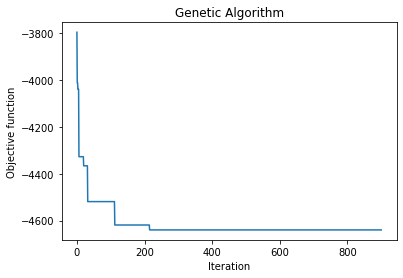

In [7]:
model.run()

In [8]:
solution = model.output_dict['variable']

In [15]:
indexes = [i for i, s in enumerate(solution) if s]

result = data.iloc[indexes,:]

print(f"W = {sum(result['w'])}, V = {sum(result['v'])}, C = {sum(result['c'])}")
result

W = 12670, V = 11.6, C = 4640


,w,v,c
1,138,0.6,293
2,1569,0.8,359
3,672,0.7,298
6,1215,0.7,278
7,1292,0.6,360
8,996,0.6,320
11,716,0.7,214
15,1534,0.9,377
16,1066,0.6,351
17,714,1.1,301


## 4.2 Реализация генетического алгоритма
Реализовать генетический алгоритм решения задачи о рюкзаке, используя свой набор генетических операторов (определяется номером в списке и другими параметрами), и получить результаты на своем наборе данных (определяется номером в списке).

0. Кодирование – выбор «генетического кода»  
  Особь – битовая последовательность размера n (кол-во грузов)  

1. Начальная популяция – кол-во особей всегда = 200:  
  1.1 случайная генерация  
  1.2 **жадный выбор, начиная со случайного груза**  

In [11]:
def w(i):
    return data['w'][i]

def v(i):
    return data['v'][i]

def c(i):
    return data['c'][i]

In [12]:
population_size = 200

def fits(solution):
    sumW = sum([w(i) if population[0][i] else 0 for i in range(0, weights - 1)])
    sumV = sum([v(i) if population[0][i] else 0 for i in range(0, weights - 1)])
    sumC = sum([c(i) if population[0][i] else 0 for i in range(0, weights - 1)])
    return sumC if sumW <= W and sumV <= V else 0

def random_solution():
    start = random.randint(0, weights - 1)
    end = start
    
    sumW = w(start)
    sumV = v(start)
    while end + 1 < weights \
            and sumW + w(end + 1) <= W \
            and sumV + v(end + 1) <= V:
        end += 1
        sumW = round(sumW + w(end), 5)
        sumV = round(sumV + v(end), 5)
    
    return [True if start <= i and i <= end else False for i in range(0, weights - 1)]

In [13]:
population = [random_solution() for i in range(0, population_size)]


def to_str(solution):
    return '[' + ''.join(['#' if i else ' ' for i in solution]) + ']'

# demonstration
for s in population[:10]:
    print(to_str(s)) 

[                       ######]
[       ##########            ]
[                           ##]
[  ##########                 ]
[ ###########                 ]
[              ############   ]
[                          ###]
[              ############   ]
[                          ###]
[##########                   ]


In [14]:
# validate a little bit
for i in population:
    assert fits(population) > 0


2. Отбор особей для скрещивания:  
  2.1 выбор каждой особи пропорционально приспособленности (рулетка)  
  2.2 **выбрать только 20% самых приспособленных особей**  


3. Скрещивание (кроссинговер) между выбранными особями. Каждая особь скрещивается 1 раз за 1 поколение, 1 пара дает 2 потомка:   
  3.1 **многоточечный с 3мя точками**  
  3.2 однородный (каждый бит от случайно выбранного родителя)  

4. Мутация:  
  4.1 **инвертирование всех битов у 1 особи**  
  4.2 случайное изменение 3х битов у 5% особей  
  4.3 добавление 1 случайной вещи 5% особей  

5. Формирование новой популяции (кол-во особей - константа)
  5.1 замена 20% худших особей из предыдущего поколения на лучших потомков  
  5.2 «штраф» за «старость» - 10% функции приспособленности, выбор лучших  
  5.3 **замена своих родителей**  

6. Оценка результата  
Наступила сходимость (функция приспособленности лучшей особи в популяциях отличается не более, чем на стоимость самой дешевой вещи) или прошло 500 поколений